In [2]:
import pyrootutils

root = pyrootutils.setup_root(
    search_from=".",
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

In [3]:
from src.models import ZSRef

/home/manish/sedoc/medvlsm/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-12-06 22:58:55,067 - Created a temporary directory at /tmp/tmpeyk9z_c4
2023-12-06 22:58:55,068 - Writing /tmp/tmpeyk9z_c4/_remote_module_non_scriptable.py


In [4]:
zsref = ZSRef(
    freesolo_cfg_path="/home/manish/sedoc/medvlsm/src/models/zsref/third_party/FreeSOLO/configs/freesolo/freesolo_30k.yaml",
    pretrained_freesolo_path="/home/manish/sedoc/medvlsm/pretrain/FreeSOLO_R101_30k_pl.pth"
)

2023-12-06 22:58:56,900 - Config '/home/manish/sedoc/medvlsm/src/models/zsref/third_party/FreeSOLO/configs/freesolo/freesolo_30k.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[12/06 22:58:56 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - coco_2017_val
  TRAIN:
  - coco_2017_train_unlabeled_densecl_r101
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: RGB
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GEN

In [5]:
from PIL import Image
import os
import numpy as np
img_id = '80472'
path2dir = './example_image' # 이미지 저장 디렉토리

img_name = f'img_{img_id}.jpg' # 이미지 파일 이름
path2img = os.path.join(path2dir, img_name) # 이미지 경로 지정
image = Image.open(path2img).convert("RGB") # 이미지 불러오기

mask_name = f'mask_{img_id}.png' # 마스크 파일 이름
path2mask = os.path.join(path2dir, mask_name) # 마스크 경로 지정
mask = Image.open(path2mask) # 마스크 불러오기
mask = np.array(mask).astype('bool') # 타입 변경

sentence = 'a man with brown hair in a dark green shirt'

In [6]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import clip

In [7]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # normalize를 위한 평균, 표준편차 값 지정
width, height = image.size # 이미지의 넓이와 높이 정보 저장

transform = T.Compose([T.Resize(640), # Image 크기 조정
                      T.ToTensor(), # Tensor로 변환
                      T.Normalize(mean, std) # Normalize
                      ])

resized_img = transform(image).unsqueeze(0)

In [8]:
resized_img =  resized_img.to("cuda")
mask = zsref(resized_img, clip.tokenize(sentence).to("cuda"), [sentence], [height], [width])

427 640


/home/manish/sedoc/medvlsm/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/manish/sedoc/medvlsm/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: u

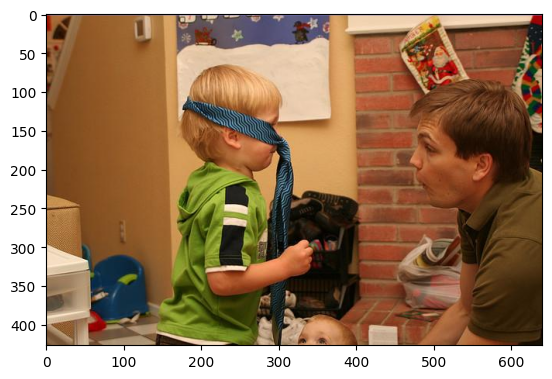

In [10]:
import matplotlib.pyplot as plt
def show_masks(anns):
    if type(anns) ==  torch.Tensor:
        if len(anns.shape) == 2:
            anns = anns.unsqueeze(0)
        anns = anns.cpu().numpy() # Tensor를 cpu로 옮기고 numpy로 변환
    else:
        anns = anns[None,:,:]
    if len(anns) == 0:
        return

    h,w = anns.shape[-2:]
    
    ax = plt.gca() # 현재의 axis 가져오기
    ax.set_autoscale_on(False)

    # sorted_anns = sorted(anns, key=lambda x: -np.sum(x)) # mask size 오름차순으로 정렬

    img = np.ones((h, w, 4)) # 빈 이미지 생성
    img[:,:,3] = 0
    for ann in anns:
        color_mask = np.concatenate([np.random.random(3), [0.7]]) # 마스크 랜덤 색상 지정 및 투명도 설명
        img[ann] = color_mask # 빈 이미지에 마스크 그려넣기
    ax.imshow(img)

plt.imshow(image)
show_masks(mask)